In [1]:
import sys
sys.path.insert(1, '../scripts')

In [2]:
# data processing
import scipy as sp
from scipy.stats import rankdata
from scipy.stats import bartlett
from scipy.special import logit
import pandas as pd
from Bio import SeqIO

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Loading data

In [3]:
all_aa = ['E', 'D', 'K', 'R', 'H', 'Q', 'N', 'S', 'T', 'G',
          'M', 'V', 'I', 'L', 'F', 'Y', 'W', 'P', 'A', 'C']

In [4]:
df_ag = pd.read_csv("../../data/aa_groups.txt")
AA_groups = {}
for index, row in df_ag.iterrows():
    aa = row['aa']
    group = row['group']
    if group not in AA_groups:
        AA_groups[group] = []
    AA_groups[group].append(aa)

In [5]:
df_codons = pd.read_csv("../../data/codons.txt")
codons = {}
for aa in all_aa:
    codons[aa] = []
    for index, row in df_codons[df_codons.aa == aa].iterrows():
        codons[aa].append(row['codon'])

In [6]:
aybrah = pd.read_csv("../../data/ref_proteomes/aybrah_species.txt", sep="\n", names=['species'])['species'].tolist()

In [7]:
model_organisms = ['Saccharomyces cerevisiae',
                   'Homo sapiens',
                   'Mus musculus',
                   'Drosophila melanogaster',
                   'Caenorhabditis elegans']

In [8]:
scerprot = []
for record in SeqIO.parse("../../data/ref_proteomes/Saccharomyces_cerevisiae.fasta", "fasta"):
    scerprot.append(record)

In [9]:
scergen = []
for record in SeqIO.parse("../../data/sc_ref_genome_coding.fasta", "fasta"):
    scergen.append(record)

## Functions

In [10]:
def get_comp(seq, states):
    dcomp = {}
    for state in states:
        dcomp[state] = 0
    for aa in seq:
        dcomp[aa] += 1
    comp = []
    for k,v in dcomp.items():
        comp.append(v / len(seq))
    return comp

In [11]:
def comp_to_dict(comp, states):
    d = {}
    for i,aa in enumerate(states):
        d[aa] = comp[i]
    return d

## Frequency of individual amino acids

In [12]:
scercomp = sp.zeros(20)
for orf in scerprot:
    seq = str(orf.seq).replace('*', '')
    scercomp = sp.add(scercomp, get_comp(seq, all_aa))
scercomp = sp.divide(scercomp, len(scerprot))

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [13]:
nt_cnt = {'A': 0, 'T':0, 'C':0, 'G':0}
for seq in scergen:
    for NT in seq.seq:
        nt_cnt[NT] += 1

nt_tot = 0
for k,v in nt_cnt.items():
    nt_tot += v        
        
nt_freq = {}
for k,v in nt_cnt.items():
    nt_freq[k] = v / nt_tot

nullcomp = []
for k,v in codons.items():
    total_freq = 0
    for codon in v:
        freq = 1
        for nt in codon:
            freq *= nt_freq[nt]
        total_freq += freq
    nullcomp.append(total_freq)
nullcomp = nullcomp / sp.sum(nullcomp)

In [14]:
diff = abs(scercomp - nullcomp)

In [15]:
diff

array([0.02204472, 0.01918967, 0.01103854, 0.03298524, 0.00908001,
       0.00239823, 0.00275364, 0.00144357, 0.00943042, 0.0058165 ,
       0.00310544, 0.00252231, 0.01211945, 0.00296066, 0.00994422,
       0.01079467, 0.00142972, 0.00450918, 0.01423467, 0.01226876])

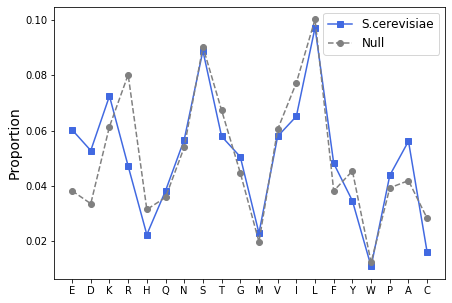

In [16]:
plt.figure(figsize=(7,5))
plt.plot(all_aa, scercomp, marker='s', color='royalblue', zorder=2)
plt.plot(all_aa, nullcomp, color='grey', linestyle='dashed', marker='o')
plt.ylabel('Proportion', fontsize=14)
plt.legend(['S.cerevisiae', 'Null'], fontsize=12)
plt.show()

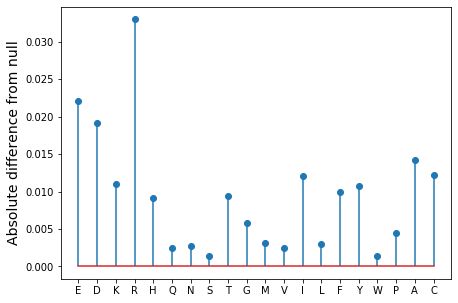

In [17]:
plt.figure(figsize=(7,5))
plt.stem(all_aa, diff, use_line_collection=True)
plt.ylabel('Absolute difference from null', fontsize=14)
plt.show()

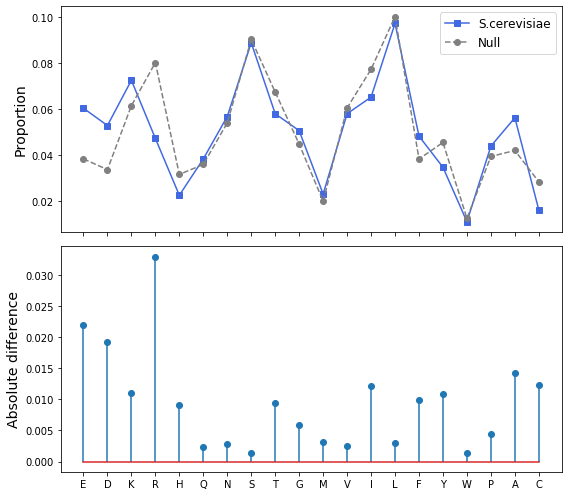

In [18]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 7))
ax1, ax2 = axes[0], axes[1]

ax1.plot(all_aa, scercomp, marker='s', color='royalblue', zorder=2)
ax1.plot(all_aa, nullcomp, color='grey', linestyle='dashed', marker='o')
ax1.set_ylabel('Proportion', fontsize=14)
ax1.legend(['S.cerevisiae', 'Null'], fontsize=12)

ax2.stem(all_aa, diff, use_line_collection=True)
ax2.set_ylabel('Absolute difference', fontsize=14)

plt.tight_layout()
plt.show()

**statistical test**

In [19]:
diffrank = len(diff) + 1 - rankdata(diff).astype(int)
diffrank

array([ 2,  3,  7,  1, 11, 18, 16, 19, 10, 12, 14, 17,  6, 15,  9,  8, 20,
       13,  4,  5])

In [20]:
# probabibilty that three out of four charged residues are in rank 1-4
p1 = (4 / 20) * (3 / 19) * (2 / 18)
p1

0.0035087719298245615

## Frequency of amino acid groups

In [21]:
comp_dict = {}
for species in aybrah:
    name = species.split(' ')
    filepath = '../../data/ref_proteomes/' + name[0] + '_' + name[1] + '.fasta'
    prot = []
    for record in SeqIO.parse(filepath, "fasta"):
        prot.append(record)
    
    comp = sp.zeros(20)
    for orf in prot:
        seq = str(orf.seq).replace('*', '').replace('X', '')
        comp = sp.add(comp, get_comp(seq, all_aa))
    comp = sp.divide(comp, len(prot))
    d = comp_to_dict(comp, all_aa)
    comp_dict[species] = d

In [22]:
df = pd.DataFrame(columns = ['species', 'AA_group', 'proportion', 'log.odds'])
for species in aybrah:
    comp = comp_dict[species]
    for group, AAs in AA_groups.items():
        rv = {}
        if species == 'Saccharomyces cerevisiae':
            rv = {'species': species}
        else:
            rv = {'species': 'others'}
        rv['AA_group'] = group
        rv['proportion'] = 0
        for AA in AAs:
            rv['proportion'] += comp[AA]
        rv['log.odds'] = logit(rv['proportion'])
        df = df.append(rv, ignore_index=True)

In [23]:
df_sc = df[df.species == 'Saccharomyces cerevisiae']
df_nonsc = df[df.species != 'Saccharomyces cerevisiae']

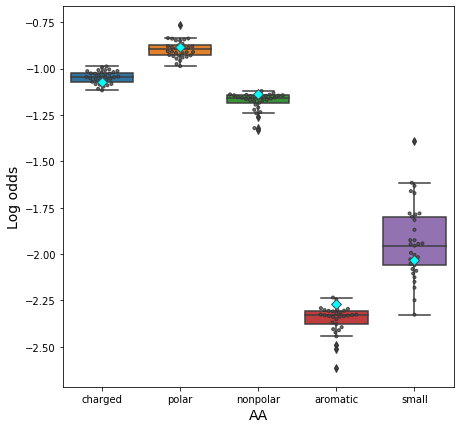

In [24]:
plt.figure(figsize=(7,7))
sns.boxplot(x="AA_group", y="log.odds", data=df)
sns.swarmplot(x="AA_group", y="log.odds", data=df_nonsc,
              color = '.3', linewidth=1, alpha=0.8, size=3)
sns.swarmplot(x="AA_group", y="log.odds", data=df_sc,
              color = 'cyan', linewidth=1, size=7, marker = 'D')
plt.ylabel('Log odds', fontsize=14)
plt.xlabel('AA', fontsize=14)
plt.show()

Statistical tests for comparing variances: <br>
- Bartlett's test, Levene's test: parametric <br>
- Conover squared ranks test <br>
- Ansari-Bradley test: measures scale parameter, requires equal median

In [25]:
charged = df.where(df.AA_group == 'charged').dropna()['log.odds']
polar = df.where(df.AA_group == 'polar').dropna()['log.odds']
polar = df.where(df.AA_group == 'polar').dropna()['log.odds']

In [26]:
bartlett(charged, polar)

BartlettResult(statistic=2.996749457949605, pvalue=0.08343175436731977)

In [27]:
AA_groups2 = {'E': ['E'],
             'D': ['D'],
             'Acidic': ['D', 'E'],
             'K': ['R'],
             'R': ['K'],
             'Basic': ['K', 'R']}

In [28]:
df2 = pd.DataFrame(columns = ['species', 'AA_group', 'proportion', 'log.odds'])
for species in aybrah:
    comp = comp_dict[species]
    for group, AAs in AA_groups2.items():
        rv = {}
        if species == 'Saccharomyces cerevisiae':
            rv = {'species': species}
        else:
            rv = {'species': 'others'}
        rv['AA_group'] = group
        rv['proportion'] = 0
        for AA in AAs:
            rv['proportion'] += comp[AA]
        rv['log.odds'] = logit(rv['proportion'])
        df2 = df2.append(rv, ignore_index=True)

In [29]:
df_sc2 = df2[df2.species == 'Saccharomyces cerevisiae']
df_nonsc2 = df2[df2.species != 'Saccharomyces cerevisiae']

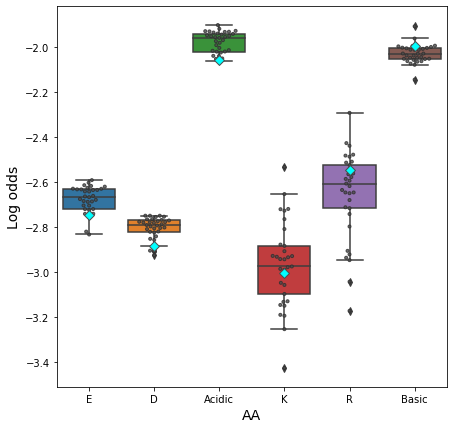

In [30]:
plt.figure(figsize=(7,7))
sns.boxplot(x="AA_group", y="log.odds", data=df2)
sns.swarmplot(x="AA_group", y="log.odds", data=df_nonsc2,
              color = '.3', linewidth=1, alpha=0.8, size=3)
sns.swarmplot(x="AA_group", y="log.odds", data=df_sc2,
              color = 'cyan', linewidth=1, size=7, marker = 'D')
plt.ylabel('Log odds', fontsize=14)
plt.xlabel('AA', fontsize=14)
plt.show()

## Supplemental Figure 3A

In [31]:
comp_dict2 = {}
for species in model_organisms:
    name = species.split(' ')
    if species == 'Saccharomyces cerevisiae':
        filepath = '../../data/ref_proteomes/' + name[0] + '_' + name[1] + '.fasta'
    else:
        filepath = '../../data/ref_proteomes/' + name[0] + '_' + name[1] + '.faa'
    prot = []
    for record in SeqIO.parse(filepath, "fasta"):
        prot.append(record)
    
    comp = sp.zeros(20)
    for orf in prot:
        seq = str(orf.seq).replace('*', '').replace('X', '').replace('U', '')
        comp = sp.add(comp, get_comp(seq, all_aa))
    comp = sp.divide(comp, len(prot))
    d = comp_to_dict(comp, all_aa)
    comp_dict2[species] = d

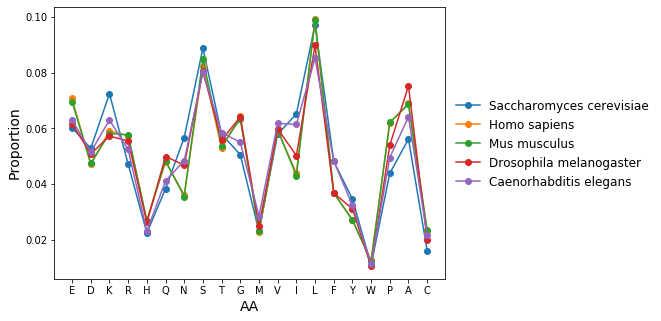

In [32]:
plt.figure(figsize=(7,5))
for species in model_organisms:
    name = species.split(' ')
    plt.plot(all_aa, list(comp_dict2[species].values()), marker='o')
plt.xlabel('AA', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.legend(model_organisms, fontsize=12, bbox_to_anchor=(1, 0.7), frameon=False)
plt.show()

## Supplemental Figure 2B

In [33]:
df3 = pd.DataFrame(columns = ['species', 'AA', 'proportion', 'log.odds'])
for species in aybrah:
    comp = comp_dict[species]
    for AA in all_aa:
        rv = {}
        if species == 'Saccharomyces cerevisiae':
            rv = {'species': species}
        else:
            rv = {'species': 'others'}
        rv['AA'] = AA
        rv['proportion'] = comp[AA]
        rv['log.odds'] = logit(rv['proportion'])
        df3 = df3.append(rv, ignore_index=True)

In [34]:
df3_sc = df3[df3.species == 'Saccharomyces cerevisiae']
df3_nonsc = df3[df3.species != 'Saccharomyces cerevisiae']

/home/rosalindpan/.local/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rosalindpan/.local/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rosalindpan/.local/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


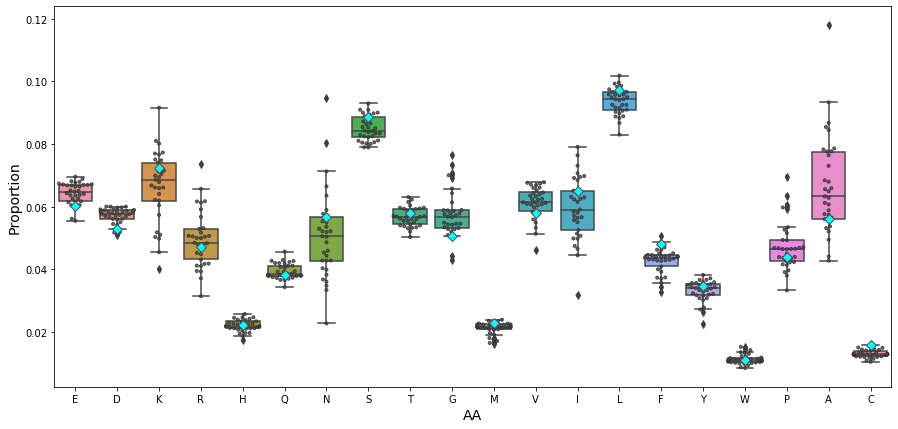

In [35]:
plt.figure(figsize=(15,7))
sns.boxplot(x="AA", y="proportion", data=df3)
sns.swarmplot(x="AA", y="proportion", data=df3_nonsc,
              color = '.3', linewidth=1, alpha=0.8, size=3)
sns.swarmplot(x="AA", y="proportion", data=df3_sc,
              color = 'cyan', linewidth=1, size=7, marker = 'D')
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('AA', fontsize=14)
plt.show()